# Bi-hourly resampling - Intelligence

I experimented with different parameters for each model, and even though some do output warning messages, the results are better.


In [1]:
!rm -rf IoT_project_1
!git clone https://github.com/paflou/IoT_project_1
import pandas as pd
%load_ext autoreload
%autoreload 2

Cloning into 'IoT_project_1'...
remote: Enumerating objects: 3561, done.
remote: Counting objects: 100% (3561/3561), done.
remote: Compressing objects: 100% (1186/1186), done.
remote: Total 3561 (delta 2359), reused 3550 (delta 2352), pack-reused 0 (from 0)
Receiving objects: 100% (3561/3561), 3.88 MiB | 12.80 MiB/s, done.
Resolving deltas: 100% (2359/2359), done.


# Data processing

Load the csv file with the data using the pandas library.

In [2]:
df = pd.read_csv("IoT_project_1/my_nullnet/export.csv")
print(df)

       ID                      Time  Count  Temperature  Humidity
0       0  2025-05-14T12:34:02.386Z      0        26.73     52.93
1       1  2025-05-14T12:34:05.741Z      0        27.50     53.12
2       0  2025-05-14T12:34:22.390Z      1        26.73     53.63
3       1  2025-05-14T12:34:25.767Z      1        27.20     55.70
4       0  2025-05-14T12:34:42.416Z      2        26.76     53.31
...    ..                       ...    ...          ...       ...
43395   0  2025-05-19T13:08:12.259Z  21703        23.68     53.15
43396   1  2025-05-19T13:08:17.106Z  21703        24.73     52.40
43397   0  2025-05-19T13:08:32.259Z  21704        23.70     53.90
43398   1  2025-05-19T13:08:37.068Z  21704        24.73     52.40
43399   0  2025-05-19T13:08:52.243Z  21705        23.68     53.12

[43400 rows x 5 columns]


Change the dtype of the "time" column to datetime64
* tip: use the pd.to_datetime function()

:Create a new dataframe with the "time" column and the column with sensor data of your interest

In [3]:
df_temp = df[['Time', 'Temperature']].copy()
df_hum = df[['Time', 'Humidity']].copy()

df_hum['Time'] = pd.to_datetime(df['Time'])
df_temp['Time'] = pd.to_datetime(df['Time'])

print(df_temp)
print(df_hum)

                                  Time  Temperature
0     2025-05-14 12:34:02.386000+00:00        26.73
1     2025-05-14 12:34:05.741000+00:00        27.50
2     2025-05-14 12:34:22.390000+00:00        26.73
3     2025-05-14 12:34:25.767000+00:00        27.20
4     2025-05-14 12:34:42.416000+00:00        26.76
...                                ...          ...
43395 2025-05-19 13:08:12.259000+00:00        23.68
43396 2025-05-19 13:08:17.106000+00:00        24.73
43397 2025-05-19 13:08:32.259000+00:00        23.70
43398 2025-05-19 13:08:37.068000+00:00        24.73
43399 2025-05-19 13:08:52.243000+00:00        23.68

[43400 rows x 2 columns]
                                  Time  Humidity
0     2025-05-14 12:34:02.386000+00:00     52.93
1     2025-05-14 12:34:05.741000+00:00     53.12
2     2025-05-14 12:34:22.390000+00:00     53.63
3     2025-05-14 12:34:25.767000+00:00     55.70
4     2025-05-14 12:34:42.416000+00:00     53.31
...                                ...       ...
43395 2

:At this point it is advisasble to resample the dataframe (i.e. hourly) and create a new one, as the data is sampled per 20 seconds, and the statistical models will not be able to handle all the data at once.


Tips:
* set the index of the dataframe to be the "time" column
* use .resample() of the pandas library function to resample the dataset and get the mean for each timestamp you create
* store this new dataframe to an appropriately named one.

In [4]:
df_hum.set_index('Time', inplace=True)
df_temp.set_index('Time', inplace=True)

temperature_df_bihourly = df_temp.resample('2h').mean()
humidity_df_bihourly = df_hum.resample('2h').mean()
print(temperature_df_bihourly)
print(humidity_df_bihourly)

                           Temperature
Time                                  
2025-05-14 12:00:00+00:00    26.145484
2025-05-14 14:00:00+00:00    25.850875
2025-05-14 16:00:00+00:00    25.867583
2025-05-14 18:00:00+00:00    26.014986
2025-05-14 20:00:00+00:00    26.302181
...                                ...
2025-05-19 04:00:00+00:00    24.451361
2025-05-19 06:00:00+00:00    24.138847
2025-05-19 08:00:00+00:00    24.015319
2025-05-19 10:00:00+00:00    24.057028
2025-05-19 12:00:00+00:00    24.236748

[61 rows x 1 columns]
                            Humidity
Time                                
2025-05-14 12:00:00+00:00  52.138140
2025-05-14 14:00:00+00:00  48.446806
2025-05-14 16:00:00+00:00  50.067986
2025-05-14 18:00:00+00:00  52.403042
2025-05-14 20:00:00+00:00  56.550486
...                              ...
2025-05-19 04:00:00+00:00  53.099972
2025-05-19 06:00:00+00:00  50.639958
2025-05-19 08:00:00+00:00  50.365639
2025-05-19 10:00:00+00:00  54.044708
2025-05-19 12:00:00+00:00 

\Use the new dataframe you created to create an array with the values of the sensor and name it approprietly.

# Statistical Models

## ARIMA model

In [5]:
# import the needed packages
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

Set a new variable that will hold the column of the dataframe with the sensor data as a list and name it approprietly.

In [6]:
temperature_series = temperature_df_bihourly['Temperature']
humidity_series = humidity_df_bihourly['Humidity']
print(temperature_df_bihourly.columns)
print(humidity_df_bihourly.columns)

Index(['Temperature'], dtype='object')
Index(['Humidity'], dtype='object')


**Split the dataset into training and testing sets (70-30)**

In [7]:
train_temperature = temperature_series[:int(len(temperature_series) * 0.7)]
test_temperature = temperature_series[int(len(temperature_series) * 0.7):]

train_humidity = humidity_series[:int(len(humidity_series) * 0.7)]
test_humidity = humidity_series[int(len(humidity_series) * 0.7):]


Load an ARIMA model and fit it to the data

There is a warning showing, but the results are the best with these parameters

In [8]:
# Temperature model
model_temp = ARIMA(train_temperature, order=(12, 1, 2))
model_temp_fit = model_temp.fit()

# Humidity model
model_hum = ARIMA(train_humidity, order=(12, 1, 1))
model_hum_fit = model_hum.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Make a forecast for as many steps as you want (prefferebly the same number of values as test set).

In [9]:
forecast_temp = model_temp_fit.forecast(steps=len(test_temperature))
forecast_hum = model_hum_fit.forecast(steps=len(test_humidity))

Plot the results Actual vs Predicted values using matplotlib.

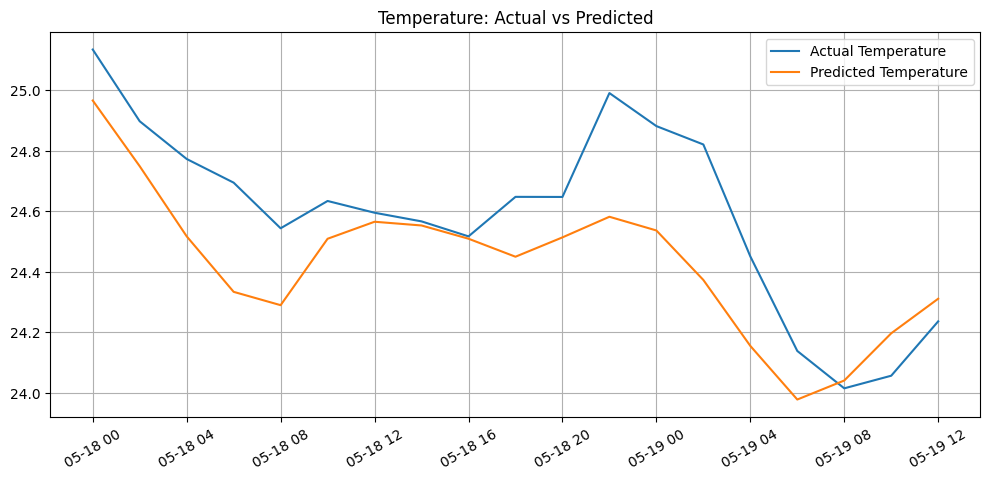

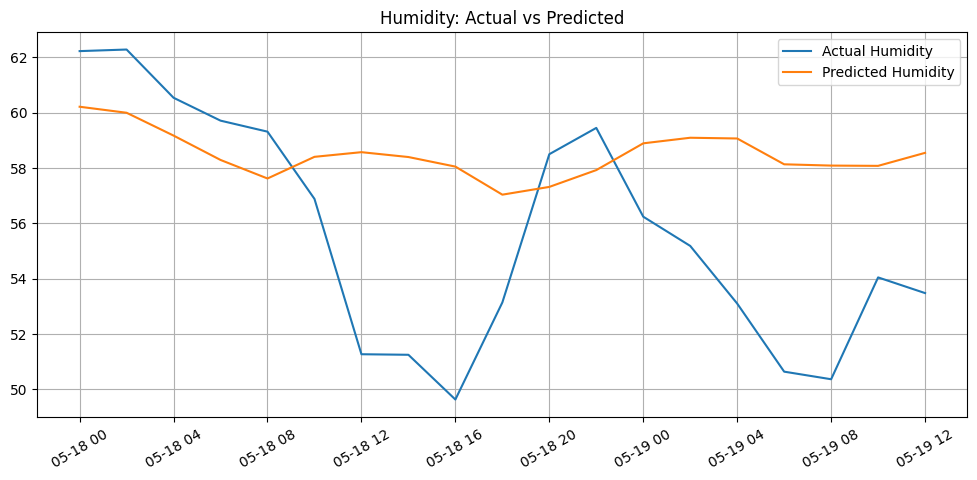

In [10]:
# Temperature plot
plt.figure(figsize=(12, 5))
plt.plot(test_temperature, label='Actual Temperature')
plt.plot(forecast_temp, label='Predicted Temperature')
plt.title('Temperature: Actual vs Predicted')
plt.xticks(rotation=30)
plt.legend()
plt.grid(True)
plt.show()

# Humidity plot
plt.figure(figsize=(12, 5))
plt.plot(test_humidity, label='Actual Humidity')
plt.plot(forecast_hum, label='Predicted Humidity')
plt.title('Humidity: Actual vs Predicted')
plt.xticks(rotation=30)
plt.legend()
plt.grid(True)
plt.show()


Calculate the below metrics for the model

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# temperature
y_true = test_temperature
y_pred = forecast_temp

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_true, y_pred)

# Print results
print("Temperature:")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape * 100:.2f}%")

# Humidity
y_true = test_humidity
y_pred = forecast_hum

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_true, y_pred)

# Print results
print("\nHumidity:")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape * 100:.2f}%")

Temperature:
MAE: 0.189
MSE: 0.053
RMSE: 0.231
MAPE: 0.77%

Humidity:
MAE: 4.031
MSE: 22.519
RMSE: 4.745
MAPE: 7.59%


# SARIMAX model
For the sarima model the same steps as the ARIMA model should be followed. Only the model call changes.

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Temperature SARIMAX model
model_sar_temp = SARIMAX(train_temperature, order=(2,1,1), seasonal_order=(2,1,2,3))
model_sar_temp_fit = model_sar_temp.fit()

# Humidity SARIMAX model
model_sar_hum = SARIMAX(train_humidity, order=(3,1,2), seasonal_order=(2,1,1,8))
model_sar_hum_fit = model_sar_hum.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
# Fit temperature SARIMAX model
model_sar_temp_fit = model_sar_temp.fit()

# Fit humidity SARIMAX model
model_sar_hum_fit = model_sar_hum.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
# Forecast temperature
forecast_temp = model_sar_temp_fit.forecast(steps=len(test_temperature))

# Forecast humidity
forecast_hum = model_sar_hum_fit.forecast(steps=len(test_humidity))


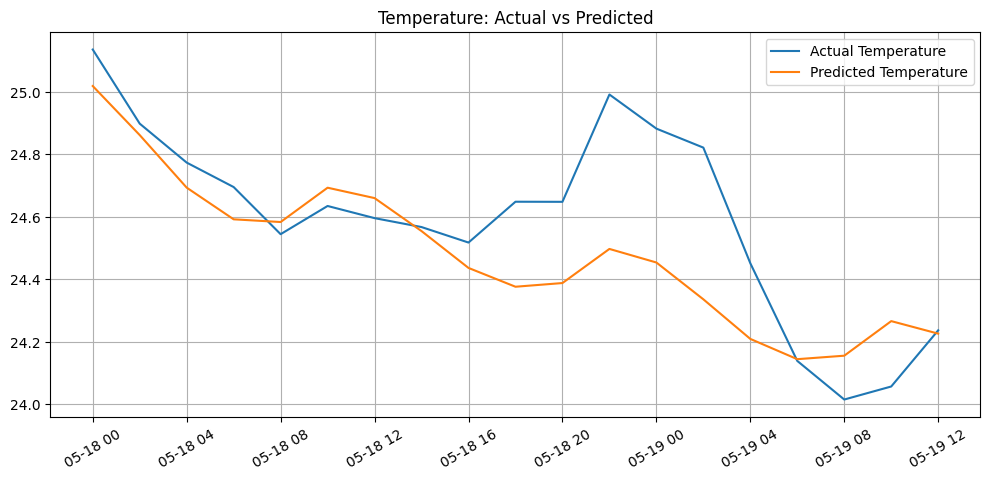

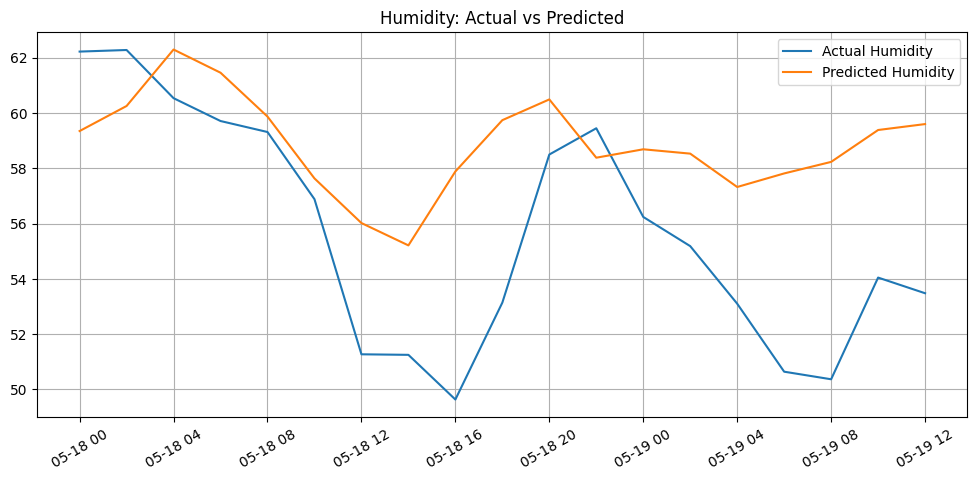

In [15]:
import matplotlib.pyplot as plt

# Temperature plot
plt.figure(figsize=(12, 5))
plt.plot(test_temperature, label='Actual Temperature')
plt.plot(forecast_temp, label='Predicted Temperature')
plt.title('Temperature: Actual vs Predicted')
plt.xticks(rotation=30)
plt.legend()
plt.grid(True)
plt.show()

# Humidity plot
plt.figure(figsize=(12, 5))
plt.plot(test_humidity, label='Actual Humidity')
plt.plot(forecast_hum, label='Predicted Humidity')
plt.title('Humidity: Actual vs Predicted')
plt.xticks(rotation=30)
plt.legend()
plt.grid(True)
plt.show()

Calculate the below metrics for the model

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Temperature metrics
mae_temp = mean_absolute_error(test_temperature, forecast_temp)
mse_temp = mean_squared_error(test_temperature, forecast_temp)
rmse_temp = np.sqrt(mse_temp)
mape_temp = mean_absolute_percentage_error(test_temperature, forecast_temp)

print("Temperature Metrics:")
print(f"MAE: {mae_temp:.3f}")
print(f"MSE: {mse_temp:.3f}")
print(f"RMSE: {rmse_temp:.3f}")
print(f"MAPE: {mape_temp * 100:.2f}%\n")

# Humidity metrics
mae_hum = mean_absolute_error(test_humidity, forecast_hum)
mse_hum = mean_squared_error(test_humidity, forecast_hum)
rmse_hum = np.sqrt(mse_hum)
mape_hum = mean_absolute_percentage_error(test_humidity, forecast_hum)

print("Humidity Metrics:")
print(f"MAE: {mae_hum:.3f}")
print(f"MSE: {mse_hum:.3f}")
print(f"RMSE: {rmse_hum:.3f}")
print(f"MAPE: {mape_hum * 100:.2f}%")

Temperature Metrics:
MAE: 0.165
MSE: 0.051
RMSE: 0.227
MAPE: 0.67%

Humidity Metrics:
MAE: 3.834
MSE: 20.454
RMSE: 4.523
MAPE: 7.19%


### You can perform the analysis for whichever sensor you choose. You may do it for all of them or one. It is advised to tune the parameters to achieve a better results but it is not necessary. You can also use GridSearchCV form sklearn to automatically optimize the parameters.

# Neural Network Models

## Data Processing and preparation

For the machine learning models the processing of the dataset changes a bit.

In [17]:
# For temperature
temperature = df_temp['Temperature'].resample('h').mean()

mean_temp = temperature.mean()
std_temp = temperature.std()
temperature_norm = (temperature - mean_temp) / std_temp

print("Temperature Mean:", mean_temp)
print("Temperature Std:", std_temp)


# For humidity
humidity = df_hum['Humidity'].resample('h').mean()

mean_hum = humidity.mean()
std_hum = humidity.std()
humidity_norm = (humidity - mean_hum) / std_hum

print("Humidity Mean:", mean_hum)
print("Humidity Std:", std_hum)


Temperature Mean: 25.288999264031535
Temperature Std: 0.678691307644451
Humidity Mean: 56.40461184674906
Humidity Std: 3.4392344033778643


Again, it is suggested you have already resampled the data as training with a large amount of instances coulf be really slow especially withoutt a dedicated GPU for acceleration. For a Machine Learning Neural Network Model we need to transform our data into information and target values. To do that we must create an array of features (past values) with a target (value after these 10 values for example).

In [18]:
look_back = 10

# Temperature sequences
X_temp = []
y_temp = []
for i in range(look_back, len(temperature_norm)):
    X_temp.append(temperature_norm[i-look_back:i])
    y_temp.append(temperature_norm[i])

X_temp = np.array(X_temp)
y_temp = np.array(y_temp)

train_size_temp = int(len(X_temp) * 0.7)
X_train_temp, y_train_temp = X_temp[:train_size_temp], y_temp[:train_size_temp]
X_test_temp, y_test_temp = X_temp[train_size_temp:], y_temp[train_size_temp:]

X_train_temp = np.reshape(X_train_temp, (X_train_temp.shape[0], X_train_temp.shape[1], 1))
X_test_temp = np.reshape(X_test_temp, (X_test_temp.shape[0], X_test_temp.shape[1], 1))


# Humidity sequences
X_hum = []
y_hum = []
for i in range(look_back, len(humidity_norm)):
    X_hum.append(humidity_norm[i-look_back:i])
    y_hum.append(humidity_norm[i])

X_hum = np.array(X_hum)
y_hum = np.array(y_hum)

train_size_hum = int(len(X_hum) * 0.7)
X_train_hum, y_train_hum = X_hum[:train_size_hum], y_hum[:train_size_hum]
X_test_hum, y_test_hum = X_hum[train_size_hum:], y_hum[train_size_hum:]

X_train_hum = np.reshape(X_train_hum, (X_train_hum.shape[0], X_train_hum.shape[1], 1))
X_test_hum = np.reshape(X_test_hum, (X_test_hum.shape[0], X_test_hum.shape[1], 1))


/tmp/ipython-input-18-4132212314.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_temp.append(temperature_norm[i])
/tmp/ipython-input-18-4132212314.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hum.append(humidity_norm[i])


The above requires array comprehension but as it the not the focus of this project please just change the look back according to the dataset you created (resample, original dataset etc.)

#### LSTM

In [87]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [88]:
# Temperature LSTM model
model_temp = Sequential()
model_temp.add(LSTM(50, input_shape=(look_back, 1)))
model_temp.add(Dense(1))
model_temp.compile(loss='mean_squared_error', optimizer='adam')

# Humidity LSTM model
model_hum = Sequential()
model_hum.add(LSTM(50, input_shape=(look_back, 1)))
model_hum.add(Dense(1))
model_hum.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [89]:
# Train temperature LSTM model
history_temp = model_temp.fit(X_train_temp, y_train_temp, epochs=100, batch_size=32)

# Train humidity LSTM model
history_hum = model_hum.fit(X_train_hum, y_train_hum, epochs=100, batch_size=32)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6299
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4467
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4072
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3008
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2820 
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2600
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2720
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2488
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2521
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2515
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2209
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2040
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2223
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2318
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1943
Epoch 16/100
3/3 ━

Plot the training accuracy over the course of the training and loss from the model.history paramater

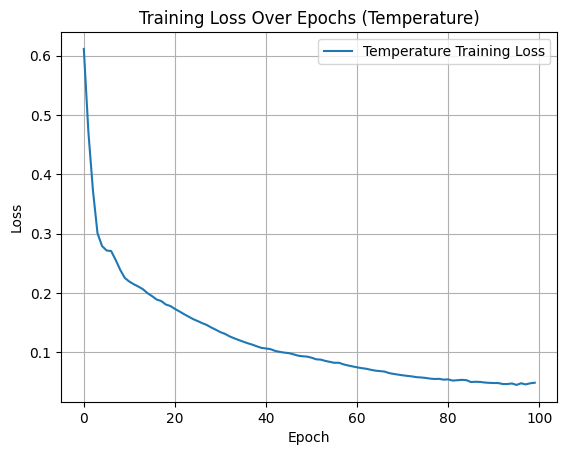

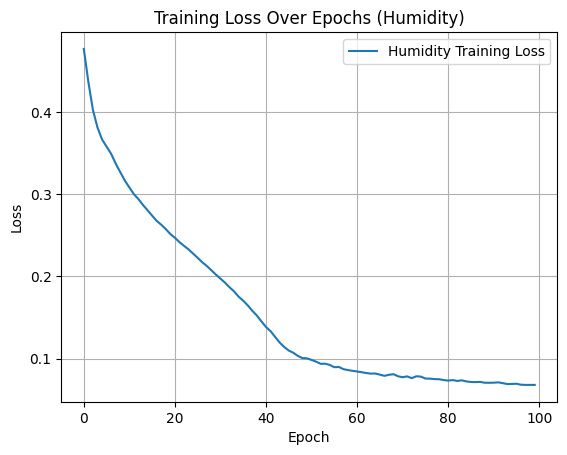

In [90]:
plt.plot(history_temp.history['loss'], label='Temperature Training Loss')
plt.title('Training Loss Over Epochs (Temperature)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history_hum.history['loss'], label='Humidity Training Loss')
plt.title('Training Loss Over Epochs (Humidity)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


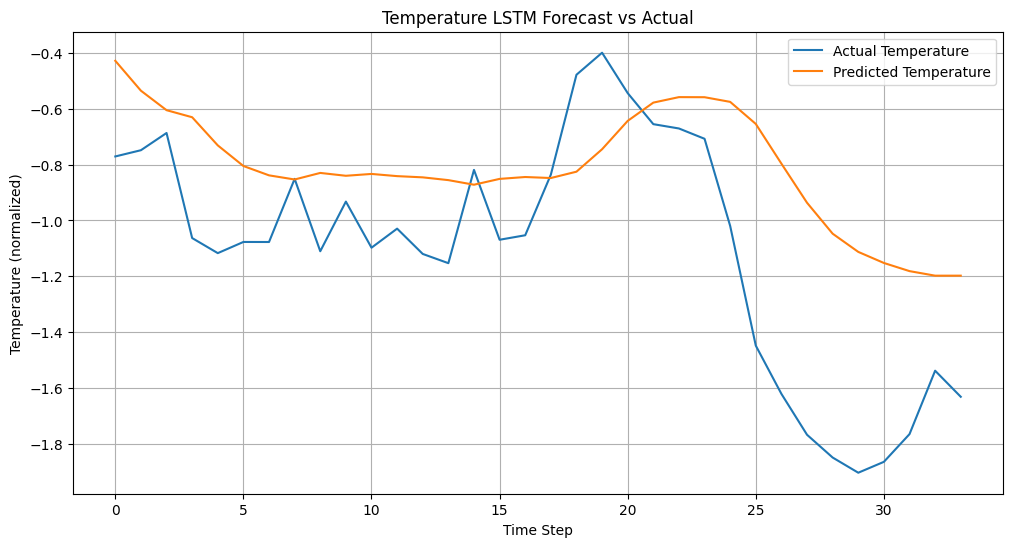

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


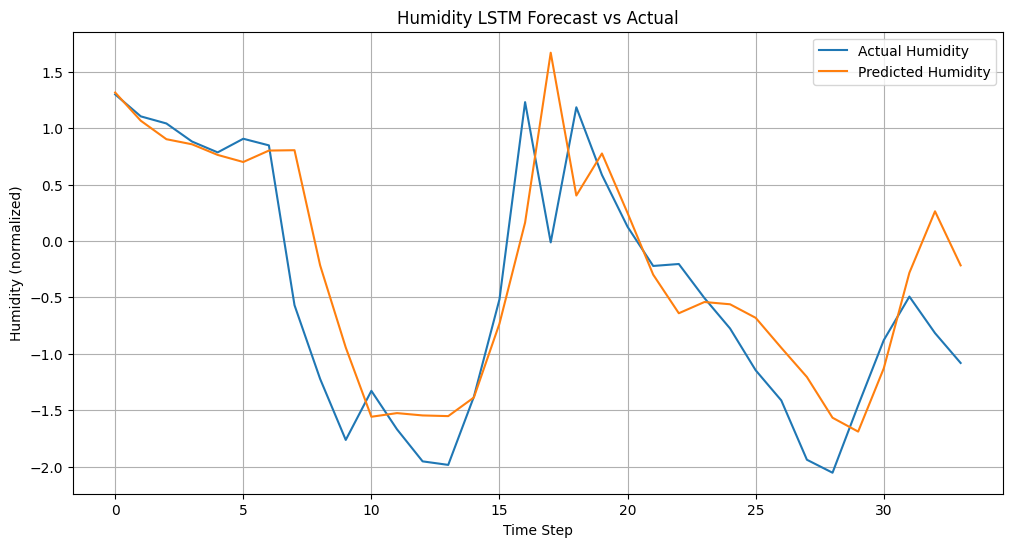

In [91]:
# Predict temperature
forecast_temp = model_temp.predict(X_test_temp)

plt.figure(figsize=(12, 6))
plt.plot(y_test_temp, label='Actual Temperature')
plt.plot(forecast_temp, label='Predicted Temperature')
plt.title('Temperature LSTM Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Temperature (normalized)')
plt.legend()
plt.grid(True)
plt.show()


# Predict humidity
forecast_hum = model_hum.predict(X_test_hum)

plt.figure(figsize=(12, 6))
plt.plot(y_test_hum, label='Actual Humidity')
plt.plot(forecast_hum, label='Predicted Humidity')
plt.title('Humidity LSTM Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Humidity (normalized)')
plt.legend()
plt.grid(True)
plt.show()


Calculate the mean_absolute_error, mean_squared_error and mean_absolute_percentage_error and the accuracy of the model.

In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# For Temperature
y_pred_temp = forecast_temp.flatten()

mae_temp = mean_absolute_error(y_test_temp, y_pred_temp)
mse_temp = mean_squared_error(y_test_temp, y_pred_temp)
rmse_temp = np.sqrt(mse_temp)
mape_temp = np.mean(np.abs((y_test_temp - y_pred_temp) / y_test_temp)) * 100
accuracy_temp = 100 - mape_temp

print("Temperature Metrics:")
print(f"MAE: {mae_temp:.3f}")
print(f"MSE: {mse_temp:.3f}")
print(f"RMSE: {rmse_temp:.3f}")
print(f"MAPE: {mape_temp:.2f}%")
print(f"Accuracy: {accuracy_temp:.2f}%\n")


# For Humidity
y_pred_hum = forecast_hum.flatten()

mae_hum = mean_absolute_error(y_test_hum, y_pred_hum)
mse_hum = mean_squared_error(y_test_hum, y_pred_hum)
rmse_hum = np.sqrt(mse_hum)
mape_hum = np.mean(np.abs((y_test_hum - y_pred_hum) / y_test_hum)) * 100
accuracy_hum = 100 - mape_hum

print("Humidity Metrics:")
print(f"MAE: {mae_hum:.3f}")
print(f"MSE: {mse_hum:.3f}")
print(f"RMSE: {rmse_hum:.3f}")
print(f"MAPE: {mape_hum:.2f}%")
print(f"Accuracy: {accuracy_hum:.2f}%")


Temperature Metrics:
MAE: 0.340
MSE: 0.176
RMSE: 0.420
MAPE: 29.77%
Accuracy: 70.23%

Humidity Metrics:
MAE: 0.427
MSE: 0.361
RMSE: 0.601
MAPE: 420.82%
Accuracy: -320.82%


#### RNN Model

\Bonus: Only the model changes between these two examples. Create your own SimpleRNN model using the LSTM model as a guidline and calculate the same training metrics as before as well as visualize the same results.

In [67]:
from keras.layers import  SimpleRNN

In [68]:
# Temperature SimpleRNN model
model_temp_rnn = Sequential()
model_temp_rnn.add(SimpleRNN(20, input_shape=(look_back, 1)))
model_temp_rnn.add(Dense(1))
model_temp_rnn.compile(loss='mean_squared_error', optimizer='adam')

# Humidity SimpleRNN model
model_hum_rnn = Sequential()
model_hum_rnn.add(SimpleRNN(20, input_shape=(look_back, 1)))
model_hum_rnn.add(Dense(1))
model_hum_rnn.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [69]:
# Train temperature RNN model
history_temp = model_temp.fit(X_train_temp, y_train_temp, epochs=100, batch_size=32)

# Train humidity RNN model
history_hum = model_hum.fit(X_train_hum, y_train_hum, epochs=100, batch_size=32)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.7313e-05
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 9.3639e-05
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.3326e-05
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.2445e-04
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.1367e-04
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 9.4625e-05
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.4527e-04
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.3754e-04
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 1.0363e-04
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3632e-04
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6686e-04
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.1909e-04
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.9214e-04
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.6398e-04
Epoch 15/100
3/3 ━━━━━━━━━━━━

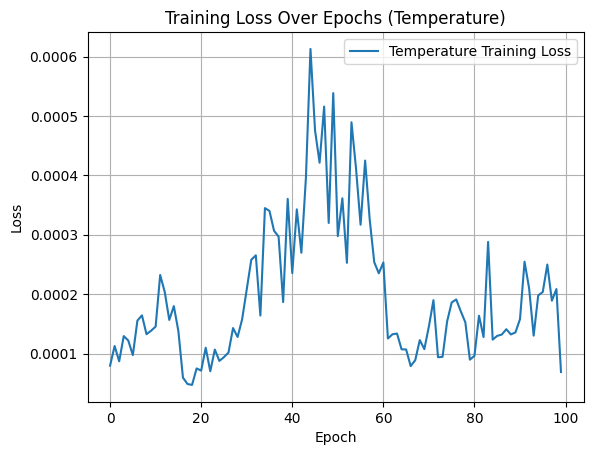

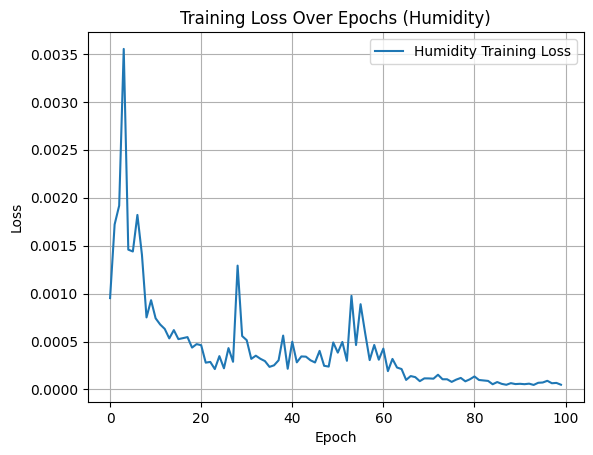

In [70]:
plt.plot(history_temp.history['loss'], label='Temperature Training Loss')
plt.title('Training Loss Over Epochs (Temperature)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history_hum.history['loss'], label='Humidity Training Loss')
plt.title('Training Loss Over Epochs (Humidity)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


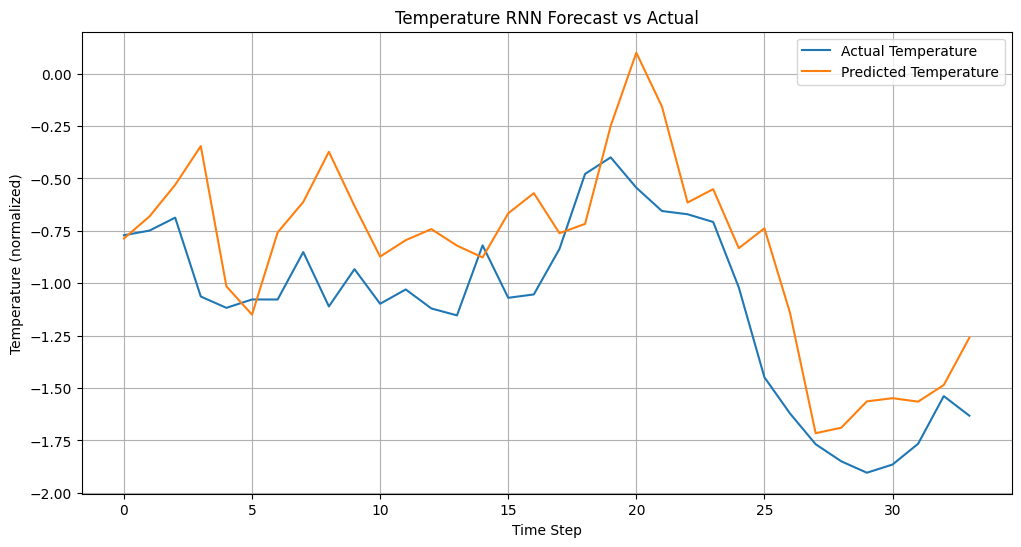

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


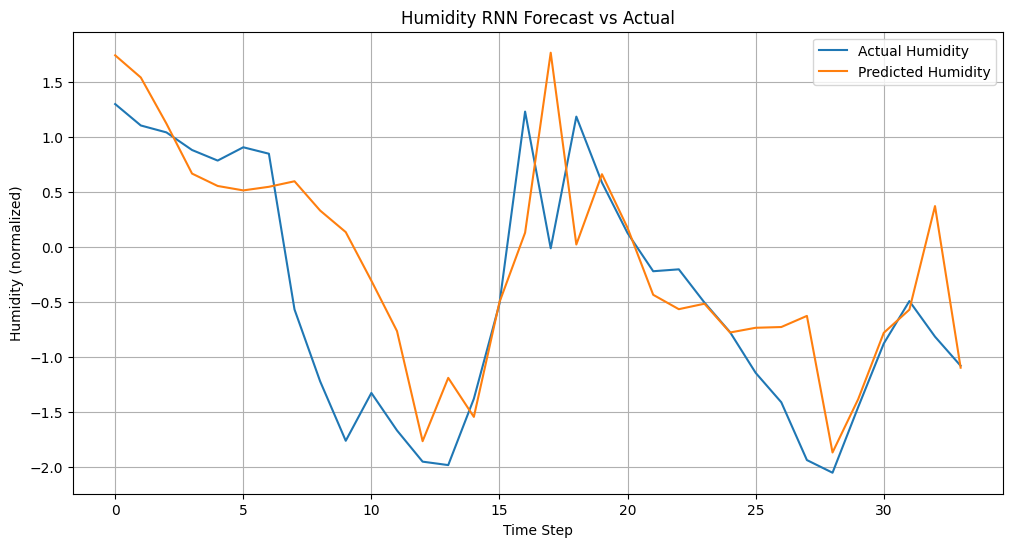

In [71]:
# Predict temperature
forecast_temp = model_temp.predict(X_test_temp)

plt.figure(figsize=(12, 6))
plt.plot(y_test_temp, label='Actual Temperature')
plt.plot(forecast_temp, label='Predicted Temperature')
plt.title('Temperature RNN Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Temperature (normalized)')
plt.legend()
plt.grid(True)
plt.show()


# Predict humidity
forecast_hum = model_hum.predict(X_test_hum)

plt.figure(figsize=(12, 6))
plt.plot(y_test_hum, label='Actual Humidity')
plt.plot(forecast_hum, label='Predicted Humidity')
plt.title('Humidity RNN Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Humidity (normalized)')
plt.legend()
plt.grid(True)
plt.show()


In [72]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# For Temperature
y_pred_temp = forecast_temp.flatten()

mae_temp = mean_absolute_error(y_test_temp, y_pred_temp)
mse_temp = mean_squared_error(y_test_temp, y_pred_temp)
rmse_temp = np.sqrt(mse_temp)
mape_temp = np.mean(np.abs((y_test_temp - y_pred_temp) / y_test_temp)) * 100
accuracy_temp = 100 - mape_temp

print("Temperature Metrics:")
print(f"MAE: {mae_temp:.3f}")
print(f"MSE: {mse_temp:.3f}")
print(f"RMSE: {rmse_temp:.3f}")
print(f"MAPE: {mape_temp:.2f}%")
print(f"Accuracy: {accuracy_temp:.2f}%\n")


# For Humidity
y_pred_hum = forecast_hum.flatten()

mae_hum = mean_absolute_error(y_test_hum, y_pred_hum)
mse_hum = mean_squared_error(y_test_hum, y_pred_hum)
rmse_hum = np.sqrt(mse_hum)
mape_hum = np.mean(np.abs((y_test_hum - y_pred_hum) / y_test_hum)) * 100
accuracy_hum = 100 - mape_hum

print("Humidity Metrics:")
print(f"MAE: {mae_hum:.3f}")
print(f"MSE: {mse_hum:.3f}")
print(f"RMSE: {rmse_hum:.3f}")
print(f"MAPE: {mape_hum:.2f}%")
print(f"Accuracy: {accuracy_hum:.2f}%")


Temperature Metrics:
MAE: 0.281
MSE: 0.120
RMSE: 0.347
MAPE: 28.62%
Accuracy: 71.38%

Humidity Metrics:
MAE: 0.547
MSE: 0.600
RMSE: 0.774
MAPE: 447.64%
Accuracy: -347.64%


# Final guidelines
* You can use this notebook or create multiple notebooks as you fit (i.e. for each sensor, for each model).
* Do not hesitate to play around with hyper parapeters optimization. While the end goal is not to achieve the best results the effort will be valued.
* Try to mess around with the data. Do the analysis for more than one sensor and try different sampling rates. We would like to see more than one datasets as a basis for your results.